<font size=4>
In the last notebook we made a neural network using Pytorch's nn.Module class. Here we'll discuss how to use torch Datasets, which allow one to efficiently do things like batch data, apply data augmentations, etc.
</font>

In [1]:
# for neural networks etc.
import torch.nn as nn
import torch

# for the dataset
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

# for the data generation
import numpy as np
import scipy.integrate

# for plotting
import matplotlib.pyplot as plt 
from matplotlib import animation
from IPython.display import HTML

<font size=4>
For this notebook, we're going to do something slightly more interesting than previously. We will take data from a Lorenz attractor (a standard chaotic dynamical system) and see if we can predict the future dynamics.
</font>

In [2]:
n_init_cond = 100

# Make initial conditions
init_x = 40*np.random.uniform(0, high=1,size=(n_init_cond,3)) 
init_x[:,0] -= 20
init_x[:,1] -= 20

# Parameter values
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

# Equations of motion. \dot x = lorenz(x)
def lorenz(t, state):
    x, y, z = state
     
    xdot = sigma * (y - x)
    ydot = x * (rho - z) - y
    zdot = x * y - beta * z
     
    return [xdot, ydot, zdot]


teval = np.linspace(0, 100, 5001) # times to sample at

trajectories = []
for init in init_x:
    trajectories.append( scipy.integrate.solve_ivp(lorenz, [0, teval[-1]], init, t_eval=teval).y )

trajectories = np.asarray(trajectories) # shape: [N init cond, 3, Time]

In [3]:
print(trajectories.shape) # 

(100, 3, 5001)


Text(0, 0.5, 'z')

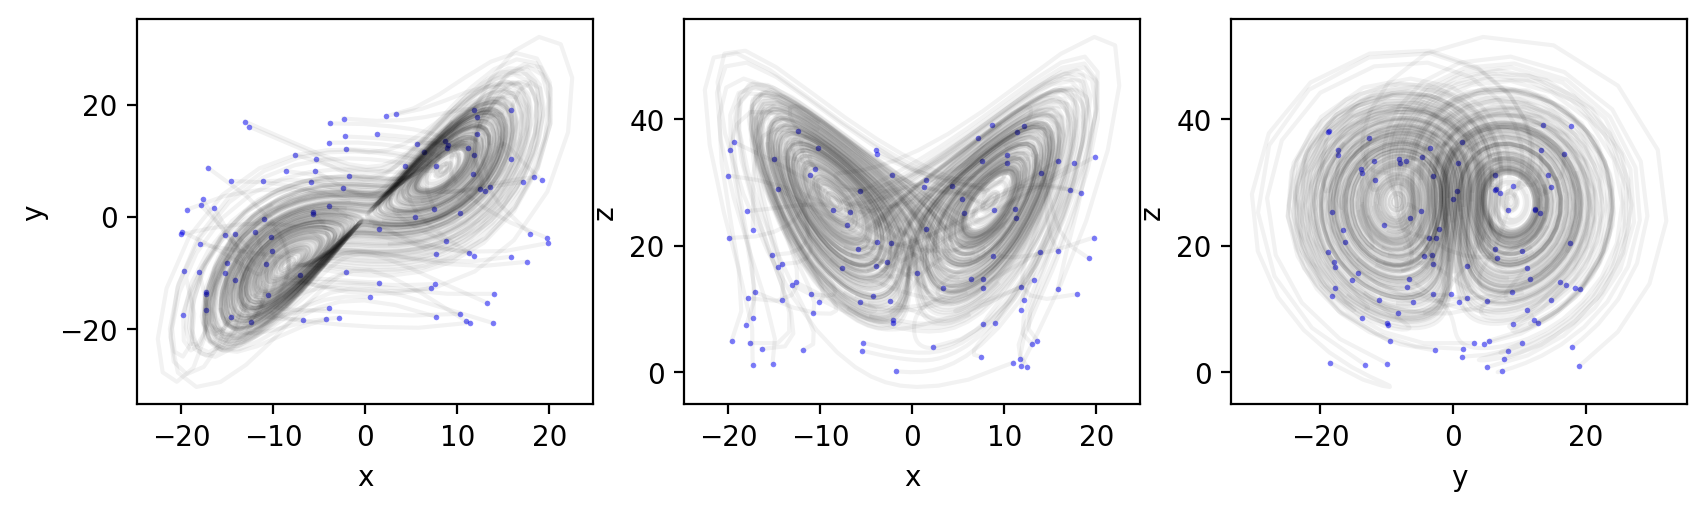

In [4]:
fig,ax=plt.subplots(1,3,figsize=(10,2.5),dpi=200)

T_stop = 100
for traj in trajectories:
    # plot init conditions in blue
    ax[0].scatter(traj[0, 0], traj[1, 0], color='b', s=4, alpha=0.5, lw=0)
    ax[1].scatter(traj[0, 0], traj[2, 0], color='b', s=4, alpha=0.5, lw=0)
    ax[2].scatter(traj[1, 0], traj[2, 0], color='b', s=4, alpha=0.5, lw=0)

    # plot trajectories
    ax[0].plot(traj[0, :T_stop], traj[1, :T_stop], color='k', alpha=0.05)
    ax[1].plot(traj[0, :T_stop], traj[2, :T_stop], color='k', alpha=0.05)
    ax[2].plot(traj[1, :T_stop], traj[2, :T_stop], color='k', alpha=0.05)

ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].set_xlabel('x')
ax[1].set_ylabel('z')

ax[2].set_xlabel('y')
ax[2].set_ylabel('z')

# The Dataset Class

<font size=4>
Datasets in pytorch have two essential methods: __init__ and __getitem__.

\_\_init__ typically will load in your data (if it can all be loaded into memory at the same time) and push it onto gpu if possible.

\_\_getitem__ will specify how to draw samples from your dataset. For supervised tasks, these will be input-output pairs. This is important, since the automated batching in pytorch works by generating random sets of indices. The getitem class tells us how an index should be mapped to a sample.

</font>


<font size=4>
First we'll start with a mini dataset class that just makes pairs of random vectors:
</font>

In [5]:
class DatasetMini(Dataset):
    def __init__(self, input_size=10, output_size=15, n_samples=150):
        x_data = np.random.randn(n_samples, input_size)
        y_data = np.random.randn(n_samples, output_size)

        self.x = torch.from_numpy(x_data).float()
        self.y = torch.from_numpy(y_data).float()

    def __len__(self): # len should always return the total number of data samples
        return self.x.shape[0]

    def __getitem__(self, idx):
        return {'input': self.x[idx], 
                'output': self.y[idx]}
    

In [ ]:
# get a sample:
dataset = DatasetMini(input_size=3, output_size=6, n_samples=12)

print("Dataset x data:", dataset.x)
print("Dataset y data:", dataset.y)

# Draw a single sample:
sample = dataset[0] # contains an input output pair
print("One sample:", sample)

# Datasets are iterable! 
for i, sample in enumerate(dataset): # it is important to define the __len__ function in the class so the iteration knows when to stop
    print(f"Sample {i}", sample)

Dataset x data: tensor([[ 0.5435,  2.1521,  1.2241],
        [-0.5940,  1.2579,  0.2694],
        [ 1.5986,  0.4524, -0.0919],
        [ 0.3036, -0.4244, -0.6236],
        [ 0.8312,  0.3588, -2.2653],
        [ 1.4271,  0.4647, -0.7602],
        [-1.3066, -1.3005,  0.7609],
        [-0.4142, -0.0628,  0.9179],
        [ 0.1370,  1.6309,  0.2460],
        [-0.9934, -1.0576,  1.0073],
        [ 1.7257, -1.1063,  1.5167],
        [ 0.4922,  0.3915,  0.5297]])
Dataset y data: tensor([[-0.8299,  0.4681,  0.6350,  0.6053, -0.1827,  1.9744],
        [-1.1243,  1.3430, -1.7644,  0.5823, -1.5088,  1.3642],
        [ 0.3234,  0.9879,  0.5545, -0.9285,  0.2033,  0.2985],
        [ 0.2467, -0.2476, -0.6463, -0.2292, -1.5867,  0.8324],
        [-0.4532,  2.6356, -0.3985, -2.0735,  0.2797, -0.4300],
        [ 0.2648, -0.9237, -0.4565, -0.7420,  1.5760, -1.4253],
        [ 1.7830,  1.4905,  0.0975,  1.0388, -0.7130, -0.8912],
        [ 0.9894,  1.8826,  2.4376, -0.7739,  0.6329, -0.6290],
        [ 0

# Data loaders:
<font size=4>
Above, we draw each sample individually. In pytorch, we can efficiently sample an entire batch of data by using a dataloader. In the case that we have to move data from cpu to gpu at every step, this also takes care of gpu memory allocation (via the "pin_memory" argument).

</font>

In [21]:
class DatasetMini_with_Index(Dataset):
    def __init__(self, input_size=5, output_size=10, n_samples=150):
        x_data = np.random.randn(n_samples, input_size)
        y_data = np.random.randn(n_samples, output_size)

        self.x = torch.from_numpy(x_data).float()
        self.y = torch.from_numpy(y_data).float()

    def __len__(self): # len should always return the total number of data samples
        return self.x.shape[0]

    def __getitem__(self, idx):
        return {'input': self.x[idx], 
                'output': self.y[idx],
                'idx': idx} ## <------------------------------- keep track of the indices for now, just so we can see what loader is doing
        

In [28]:
dataset = DatasetMini_with_Index()

indices = np.arange(len(dataset))
sampler = SubsetRandomSampler(indices) # this will generate random samples from our indices
loader = torch.utils.data.DataLoader(dataset, batch_size=12, num_workers=0, sampler=sampler, pin_memory=False)

# loader is an iterable, but we cannot index it! I.e. we can't do batch = loader[0]. 
# Instead, this is how we can get the first sample:
batch = next(x for x in loader) 

#This batch will contain several samples. Let's look at the indices the samples were drawn from:
print("Dataset indices contained in first batch:", batch['idx'])
print("Each batch has same keys as an individual sample:", sample.keys())
print("Each key in the dict will be stacked, so it is now size [Batchsize, Input dim]:", sample['input'].shape)

Dataset indices contained in first batch: tensor([ 71,  44,  28, 129,  70, 117,  26,  25, 133,  29, 127,  53])
Each batch has same keys as an individual sample: dict_keys(['input', 'output'])
Each key in the dict will be stacked, so it is now size [Batchsize, Input dim]: torch.Size([3])


In [29]:
# We can make sure the inputs are those that we would also get from indexing the model:
print("First sample in batch:\t\t", batch['input'][0])
print("First sample drawn from dataset:", dataset[batch['idx'][0]]['input'])

First sample in batch:		 tensor([ 1.2075, -0.7320,  0.9022, -0.7565, -0.0528])
First sample drawn from dataset: tensor([ 1.2075, -0.7320,  0.9022, -0.7565, -0.0528])


<font size=4>
Make sure you understand how batches are formed by looking at the outputs above! To try yourself, try to draw a new batch and print the inputs and outputs. Then print the inputs and outputs you'd get by using the indices to take samples directly from the dataset.

The real benefit of this automated batching (with SubsetRandomSampler/DataLoader) is shown in the following cell: the batches are all made automatically:
</font>

In [30]:
for batch in loader:
    print("Idx:", batch['idx'])

Idx: tensor([  7,  61,  10,   6,   8, 114,  23,  72, 138, 103, 137,  70])
Idx: tensor([ 33,  35,  11, 107,   2, 116,  81,   4,   9,  36, 124, 123])
Idx: tensor([ 21, 139, 125,  75,  79, 142,  58,  26,  43, 144, 106,  93])
Idx: tensor([ 68,  65,  95,  29,  91,  97,  83, 148,  55,  45,  64,  88])
Idx: tensor([119,  90, 130, 113, 140, 136,  62, 115,  37,  74, 111,  73])
Idx: tensor([ 39,  24, 135, 133, 122, 117, 108,  15,  82,  41,  66, 149])
Idx: tensor([  1,  19,  57, 127,  69,  78,  12, 145, 126,  67,  54,  31])
Idx: tensor([ 40, 109,   0,  44,  46,  17,  60,  56,  71, 132,  84,  96])
Idx: tensor([ 50,  34, 128,  14,  25,  48,  52, 104,  28,  22,  27, 129])
Idx: tensor([ 94,  49, 147, 141, 131,  20, 120,  92, 118,  47,  85,  38])
Idx: tensor([ 30,  86, 110, 112,  32, 100,  59, 102, 146,  53, 143,  98])
Idx: tensor([ 13,  42,  76,  51, 134, 105,   5, 121,  16,  80,  77,  63])
Idx: tensor([ 87,  18, 101,   3,  89,  99])


<font size=4>
Why do you think the last batch is sampler has a different size? (Think about dataset size! Try doing the following: change the "indices" argument of the Sampler and see how the output of the above cell changes. For example instead of np.arange(len(dataset)), do np.arange(40))
</font>

# Dataloader for the Lorenz dynamics data

<font size=4>
Now we'll put it all together for our real dataset. Note that I typically make the loader into an attribute of the dataset itself, as you can see below.

</font>

In [31]:
print(trajectories.shape)

(100, 3, 5001)


In [ ]:
class DatasetLorenz(Dataset):
    def __init__(self, 
                 trajectory_data, # our trajectory data. Shape: [n init cond, 3, T]
                 dT=10, # the time horizon over which we'd like to make predictions
                 batch_size=128
                ):
        
        self.data = trajectory_data # Shape: [n init cond, 3, T]
        self.data = self.data.transpose(0,2,1) # Shape: [n init cond, T, 3]
        self.data = torch.from_numpy(self.data).float()
        self.dT = dT

        self.loader = self.make_loader(indices=np.arange(len(self)), batch_size=batch_size, num_workers=0, pin_memory=False)
        

    def __len__(self): # len should always return the total number of data samples
        return self.data.shape[0] * (self.data.shape[1] - self.dT) # for each initial condition, we can take a sample from 0 to the -dT'th index

    def __getitem__(self, idx):
        idx = np.unravel_index(idx, shape=(self.data.shape[0], self.data.shape[1] - self.dT))

        x0 = self.data[idx[0], idx[1], :]
        xT = self.data[idx[0], idx[1]+self.dT, :]
        
        return {'input': x0, 
                'output': xT,
                'idx': idx}

    def make_loader(self, indices, batch_size, num_workers, pin_memory=True):
            sampler = SubsetRandomSampler(indices)
            loader = torch.utils.data.DataLoader(self, 
                batch_size=batch_size,
                num_workers=num_workers,
                sampler=sampler,
                pin_memory=pin_memory)
            
            return loader


In [39]:
dataset_lorenz = DatasetLorenz(trajectories)
print(dataset_lorenz.data.shape)

torch.Size([100, 5001, 3])


In [50]:
class NNModel(nn.Module):
    def __init__(self, 
                 input_size=1, # number of channels/dimensions of the input
                 output_size=1, # number of channels/dimensions of the output
                 n_channels=64, # number of channels/dimensions of inner layers
                 n_layers=2, # number of intermediate layers
                 activation_fct=nn.ReLU(),
                 optimization_hyperparameters={'LR': 1e-3}):

        super().__init__() # initialize nn.Module

        ## MAKE THE NETWORK
        self.layers = nn.ModuleList() # this will be a list of all our neural network layers. You can append to it just like to a normal list

        self.layers.append(nn.Linear(input_size, n_channels)) # First layer
        self.layers.append(activation_fct) # Activation on first layer

        for _ in range(n_layers-1):
            self.layers.append(nn.Linear(n_channels, n_channels)) # intermediate layer
            self.layers.append(activation_fct) # activation
        
        self.layers.append(nn.Linear(n_channels, output_size)) # Last layer. Don't activate, unless you want values in [0, infty] 

        # Put on device
        self.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

        ## MAKE THE OPTIMIZER. 
        # This will keep track of things like learning rate, optimization steps, and which parameters we want to apply gradients to.
        # self.parameters will get all the parameters in the layers that we have initialized so far, so make sure to do this step last.
        self.optimizer = torch.optim.Adam(self.parameters(), lr=optimization_hyperparameters['LR'])



    def forward(self, input):
        x = input.clone()

        for layer in self.layers:
            x = layer(x) # apply each layer to the input
            
        return x # this is our prediction


In [51]:
model = NNModel(input_size=3, # number of channels/dimensions of the input
                 output_size=3, # number of channels/dimensions of the output
                 n_channels=64, # number of channels/dimensions of inner layers
                 n_layers=4, # number of intermediate layers
                 activation_fct=nn.ReLU(),
                 optimization_hyperparameters={'LR': 1e-3})

# Now do training procedure by iterating over the dataset a total number of *n_epochs* times.

In [77]:
# First, put the data on gpu so it will be faster. This step may be skipped
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_lorenz = DatasetLorenz(trajectories, dT=3, batch_size=128)
dataset_lorenz.data = dataset_lorenz.data.to(device)
model.to(device)

NNModel(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [78]:
#prediction_history = []
loss_history = []

n_epochs = 2
print("Len dataset:", len(dataset_lorenz), "Steps per epoch: ", len(dataset_lorenz.loader))

import time
t0 = time.time()
for epoch in range(n_epochs):
    for batch in dataset_lorenz.loader:
        inputs = batch['input'].float()
        outputs = batch['output'].float()

        model.optimizer.zero_grad() # clear any gradients, so that we can calculate them anew

        predictions = model(inputs)

        loss = torch.mean((predictions - outputs)**2) # minimize mean square error
        
        loss.backward() # calculate gradients
        model.optimizer.step() # will do a gradient step

        loss_history.append(loss.detach().cpu().numpy())
    
    print(f"Epoch {epoch}, Loss: {loss:0.3f}, Time: {time.time()-t0:0.2f}s")


Len dataset: 499800 Steps per epoch:  3905
Epoch 0, Loss: 0.012, Time: 16.59s
Epoch 1, Loss: 0.023, Time: 33.16s


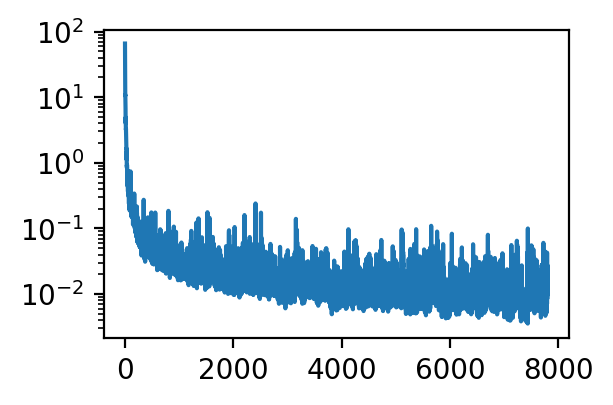

In [79]:
fig,ax=plt.subplots(1,1,figsize=(3,2),dpi=200)

ax.semilogy(loss_history)

# Verification
It is non-trivial to verify that our predictions are actually "good". To do this, we'll make a scatter plot of the true vs predicted future time points.

In [57]:
print(dataset_lorenz.data.shape)

torch.Size([100, 5001, 3])


(10000, 3) torch.Size([10000, 3])


Text(0.5, 1.0, 'z')

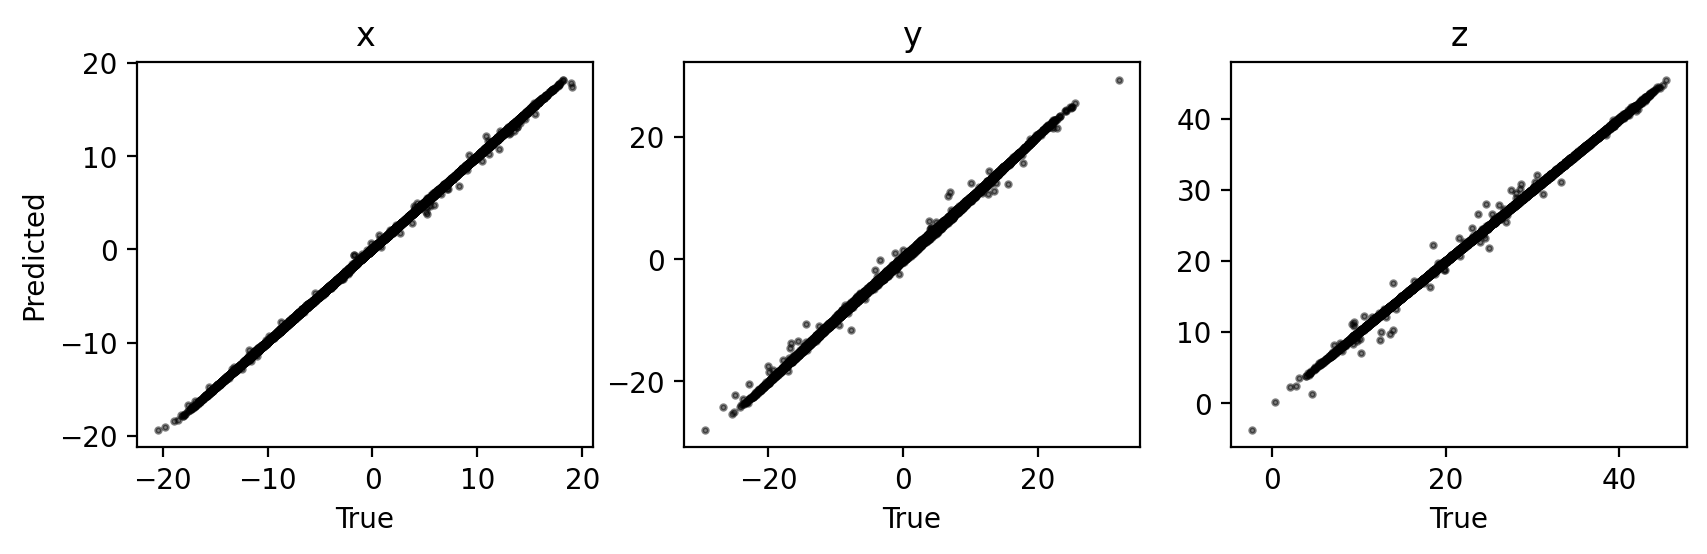

In [80]:
fig,ax=plt.subplots(1,3,figsize=(10,2.5),dpi=200)

inpt_data  = dataset_lorenz.data[:,:-dataset_lorenz.dT].to(device).float() # inputs
outpt_data = dataset_lorenz.data[:,dataset_lorenz.dT:].to(device).float() # predictions

downsample = 50
inpt_data = inpt_data[:,::downsample]
outpt_data = outpt_data[:,::downsample]
inpt_data = inpt_data.reshape(-1, 3) # Want to flatten the first two indices
outpt_data = outpt_data.reshape(-1,3).detach().cpu().numpy()

predictions = model(inpt_data).detach().cpu().numpy()

print(outpt_data.shape, inpt_data.shape)

for i in range(3):
    ax[i].scatter(outpt_data[:,i], predictions[:,i], s=4, color='k', alpha=0.5)
    ax[i].set_xlabel('True')

ax[0].set_ylabel('Predicted')

ax[0].set_title('x')
ax[1].set_title('y')
ax[2].set_title('z')

<font size=4>
We can also see how well the network is able to "roll out" the predictions, i.e. if we can use the network to evolve the state several steps into the future. To see how errors compound when doing this, see the plot below.

This fast divergence of trajectories, even starting from small errors, reflects the chaotic nature of the dynamics.
</font>

(101, 3)


Text(0, 0.5, 'x')

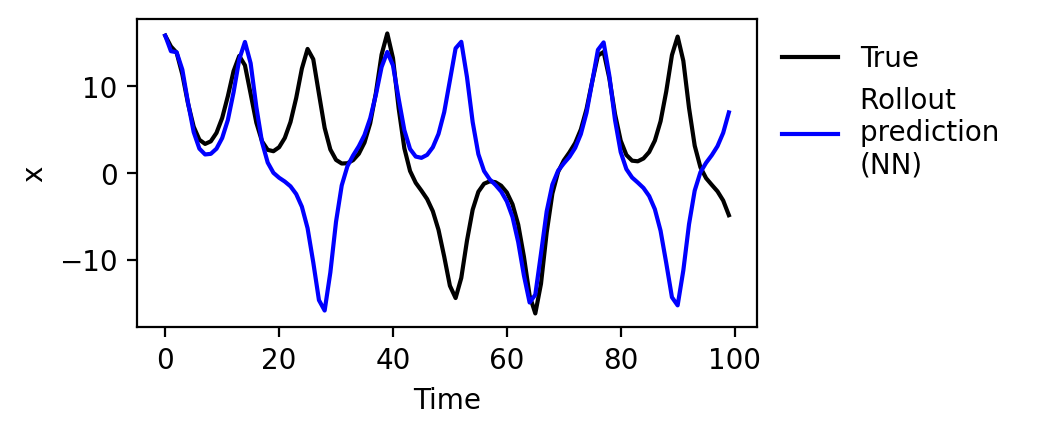

In [93]:
inpt_data  = dataset_lorenz.data[0,::dataset_lorenz.dT].float().to(device)#.detach().cpu().numpy() # inputs

init_cond = inpt_data[0]
predictions = [init_cond]
for i in range(100):
    pred = model(predictions[-1]).detach() # make next step prediction using last element
    predictions.append(pred)

predictions = torch.stack(predictions).detach().cpu().numpy()
print(predictions.shape)

fig,ax=plt.subplots(1,1,figsize=(4,2),dpi=200)

ax.plot(inpt_data[:100,0].detach().cpu().numpy(), color='k', label='True')
ax.plot(predictions[:100,0], color='b', label='Rollout \nprediction \n(NN)')

ax.legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left', )

ax.set_xlabel('Time')
ax.set_ylabel('x')